### Implement anomaly detection for given credit card dataset using Autoencoder and build the model 


Missing values in dataset: 0

Training normal samples: 227451
Testing normal samples: 56864
Testing fraud samples: 98


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 28)                  │             868 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │             406 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 28)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 30)                  │             870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,564 (10.02 KB)

 Trainable params: 2,564 (10.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.8001 - mae: 0.5706 - val_loss: 0.7073 - val_mae: 0.5185
Epoch 2/15
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.7110 - mae: 0.5063 - val_loss: 0.6860 - val_mae: 0.4976
Epoch 3/15
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.6995 - mae: 0.4948 - val_loss: 0.6799 - val_mae: 0.4909
Epoch 4/15
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.6953 - mae: 0.4902 - val_loss: 0.6770 - val_mae: 0.4877
Epoch 5/15
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.6931 - mae: 0.4876 - val_loss: 0.6752 - val_mae: 0.4856
Epoch 6/15
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.6915 - mae: 0.4858 - val_loss: 0.6741 - val_mae: 0.4847
Epoch 7/15
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.6902 - mae: 0.4844 - val_loss: 0.6726 - val_mae: 0.4831
Epoch 8/15
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.6889 - mae: 0.4831 - val_loss: 0.6715 - val_mae: 0.4824
Epoch 9/15
1777/1777 ━━━━━━━━━━━

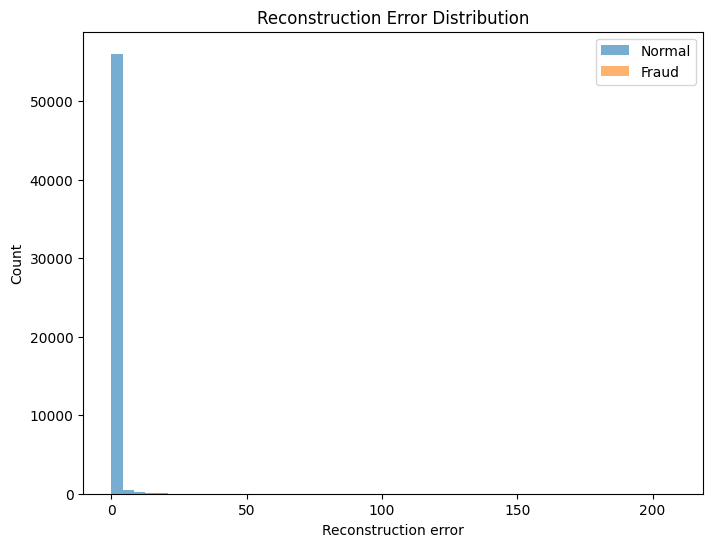

Chosen threshold (95th percentile): 1.424612

Confusion Matrix:
[[54103  2761]
 [   10    88]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     56864
           1       0.03      0.90      0.06        98

    accuracy                           0.95     56962
   macro avg       0.52      0.92      0.52     56962
weighted avg       1.00      0.95      0.97     56962



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc

# For reproducibility
np.random.seed(42)

data = pd.read_csv("creditcard.csv")

print("\nMissing values in dataset:", data.isnull().sum().sum())

# Separate features and target
X = data.drop(['Class'], axis=1)
y = data['Class']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Use only normal (non-fraud) data for training
X_train_normal = X_train[y_train == 0]
X_test_normal = X_test[y_test == 0] # 0-normal, 1-fraud
X_test_fraud = X_test[y_test == 1]

print(f"\nTraining normal samples: {X_train_normal.shape[0]}")
print(f"Testing normal samples: {X_test_normal.shape[0]}")
print(f"Testing fraud samples: {X_test_fraud.shape[0]}")

input_dim = X_train_normal.shape[1]   # Number of features
encoding_dim = 14                     # Latent dimension (bottleneck)

# Encoder layers
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim * 2, activation='relu')(input_layer)
encoder = Dense(encoding_dim, activation='relu')(encoder)

decoder = Dense(encoding_dim * 2, activation='relu')(encoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)

# Combine encoder and decoder into autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',      # Mean Squared Error (reconstruction loss)
    metrics=['mae']  # Mean Absolute Error for monitoring
)

autoencoder.summary()

# Train the Autoencoder

history = autoencoder.fit(
    X_train_normal, X_train_normal,    # Input = Output
    epochs=15,
    batch_size=128,
    validation_data=(X_test_normal, X_test_normal),
    verbose=1
)

# Evaluate Reconstruction Error

reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_test.values})

plt.figure(figsize=(8, 6))
plt.hist(error_df[error_df.True_class == 0].Reconstruction_error, bins=50, alpha=0.6, label="Normal")
plt.hist(error_df[error_df.True_class == 1].Reconstruction_error, bins=50, alpha=0.6, label="Fraud")
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction error")
plt.ylabel("Count")
plt.legend()
plt.show()

# Determine threshold for anomaly detection

threshold = np.percentile(error_df.Reconstruction_error, 95)
print(f"Chosen threshold (95th percentile): {threshold:.6f}")

error_df['Predicted'] = (error_df.Reconstruction_error > threshold).astype(int)

print("\nConfusion Matrix:")
print(confusion_matrix(error_df.True_class, error_df.Predicted))

print("\nClassification Report:")
print(classification_report(error_df.True_class, error_df.Predicted))


### (a) Import Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc

# For reproducibility
np.random.seed(42)

### (b) Access the Dataset

In [ ]:
data = pd.read_csv("creditcard.csv")

print("\nMissing values in dataset:", data.isnull().sum().sum())

# Separate features and target
X = data.drop(['Class'], axis=1)
y = data['Class']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Use only normal (non-fraud) data for training
X_train_normal = X_train[y_train == 0]
X_test_normal = X_test[y_test == 0] # 0-normal, 1-fraud
X_test_fraud = X_test[y_test == 1]

print(f"\nTraining normal samples: {X_train_normal.shape[0]}")
print(f"Testing normal samples: {X_test_normal.shape[0]}")
print(f"Testing fraud samples: {X_test_fraud.shape[0]}")

### (c) Encoder – converts input into latent representation

In [ ]:
input_dim = X_train_normal.shape[1]   # Number of features
encoding_dim = 14                     # Latent dimension (bottleneck)

# Encoder layers
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim * 2, activation='relu')(input_layer)
encoder = Dense(encoding_dim, activation='relu')(encoder)

### (d) Decoder – reconstructs input from latent representation

In [ ]:
decoder = Dense(encoding_dim * 2, activation='relu')(encoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)

# Combine encoder and decoder into autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoder)

### (e) Compile the models with Optimizer, Loss, and Evaluation Metrics

In [2]:
autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',      # Mean Squared Error (reconstruction loss)
    metrics=['mae']  # Mean Absolute Error for monitoring
)

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 28)                  │             868 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │             406 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 28)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 30)                  │             870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,564 (10.02 KB)

 Trainable params: 2,564 (10.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the Autoencoder

history = autoencoder.fit(
    X_train_normal, X_train_normal,    # Input = Output
    epochs=15,
    batch_size=128,
    validation_data=(X_test_normal, X_test_normal),
    verbose=1
)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


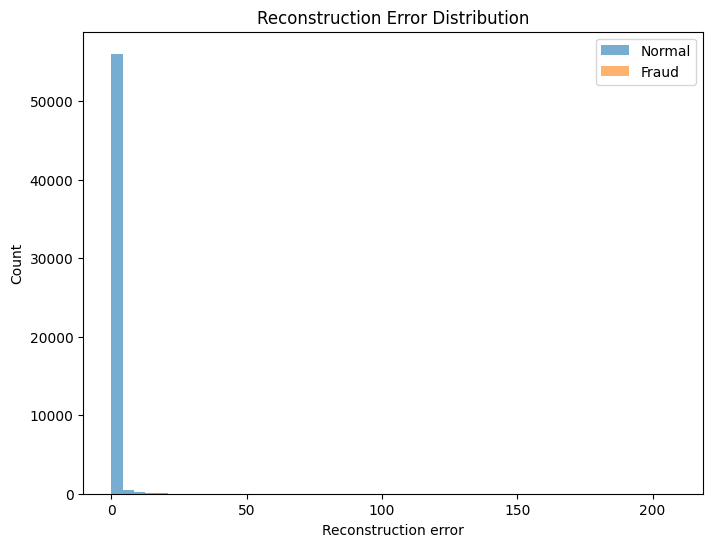

In [3]:
# Evaluate Reconstruction Error

reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_test.values})

plt.figure(figsize=(8, 6))
plt.hist(error_df[error_df.True_class == 0].Reconstruction_error, bins=50, alpha=0.6, label="Normal")
plt.hist(error_df[error_df.True_class == 1].Reconstruction_error, bins=50, alpha=0.6, label="Fraud")
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction error")
plt.ylabel("Count")
plt.legend()
plt.show()

In [4]:
# Determine threshold for anomaly detection

threshold = np.percentile(error_df.Reconstruction_error, 95)
print(f"Chosen threshold (95th percentile): {threshold:.6f}")

error_df['Predicted'] = (error_df.Reconstruction_error > threshold).astype(int)

print("\nConfusion Matrix:")
print(confusion_matrix(error_df.True_class, error_df.Predicted))

print("\nClassification Report:")
print(classification_report(error_df.True_class, error_df.Predicted))


Chosen threshold (95th percentile): 1.424612

Confusion Matrix:
[[54103  2761]
 [   10    88]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     56864
           1       0.03      0.90      0.06        98

    accuracy                           0.95     56962
   macro avg       0.52      0.92      0.52     56962
weighted avg       1.00      0.95      0.97     56962

